## Test project
* Requirements
    * Stocks folder [Huge Stock Market Dataset (BORIS MARJANOVIC, Kaggle)](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)

Note: All code has been generated using ChatGPT.

Idea
* Load data
* Create event variables for larger dips
* Run a machine learning algorithm on these data

Let us start by loading data for one stock. Let us also plot the value of the stock for the entire time period to confirm that the data were loaded correctly.

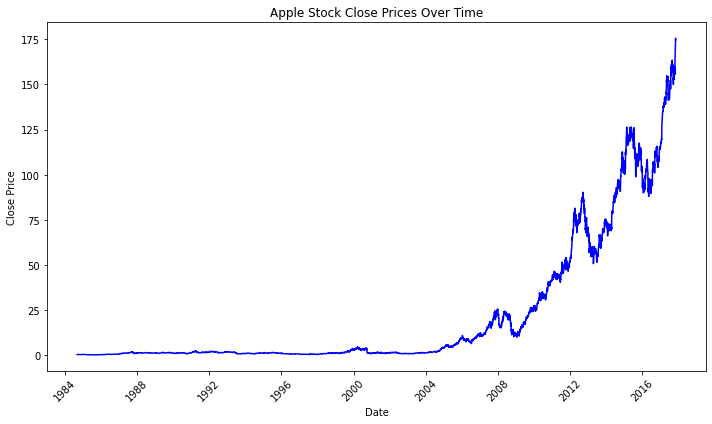

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file path for Apple stock data
apple_stock_file = 'Stocks/aapl.us.txt'  # Update the file path based on the file's location

# Load the data into a pandas DataFrame
apple_stock_data = pd.read_csv(apple_stock_file)

# Convert the 'Date' column to a datetime object
apple_stock_data['Date'] = pd.to_datetime(apple_stock_data['Date'])

# Plotting the Close prices over time
plt.figure(figsize=(10, 6))
plt.plot(apple_stock_data['Date'], apple_stock_data['Close'], color='blue')
plt.title('Apple Stock Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


It appears that the data have been loaded successfully.

Next, let us generate the event variables.

In [27]:
# Calculate daily percentage change in Close price
apple_stock_data['Daily_Return'] = apple_stock_data['Close'].pct_change() * 100

# Set threshold values for events
threshold_1 = -1  # 1% dip
threshold_10 = -10  # 10% dip

# Create 'event1' for a 1% dip
apple_stock_data['event1'] = apple_stock_data['Daily_Return'] <= threshold_1

# Create 'event2' for a 10% dip
apple_stock_data['event2'] = apple_stock_data['Daily_Return'] <= threshold_10

# Display the modified DataFrame
apple_stock_data.head()


,Date,Open,High,Low,Close,Volume,OpenInt,Daily_Return,event1,event2
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,NaN,False,False
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,-0.599226,False,False
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,1.822756,False,False
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,-2.992867,True,False
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,5.548080,False,False


Above we have created two variables: `event1` and `event2` which correspond to a $1\%$ and a $10\%$ decrease respectively in the stock's value in one day.

In [20]:
# Calculate frequency of event1 (5% dip) and event2 (10% dip)
event1_count = apple_stock_data['event1'].sum()
event2_count = apple_stock_data['event2'].sum()

# Total number of data points
total_data_points = len(apple_stock_data)

# Calculate frequencies
event1_frequency = event1_count / total_data_points
event2_frequency = event2_count / total_data_points

print(f"Frequency of 1% dip (event1): {event1_frequency * 100:.2f}%")
print(f"Frequency of 10% dip (event2): {event2_frequency * 100:.2f}%")


Frequency of 1% dip (event1): 29.73%
Frequency of 10% dip (event2): 0.26%


Next, let us try to train a machine learning algorithm to predict when these events take place. Let us first try to predict the $1\%$ dips.

In [25]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


# Features (X) and Target variable (y)
# Considering 'Open', 'High', 'Low', 'Close', 'Volume' as features for simplicity
features = ['Open', 'High', 'Low', 'Close', 'Volume']
X = apple_stock_data[features]
y = apple_stock_data['event1']  # Change to 'event2' for 10% dip

# Define the number of splits for time series cross-validation
n_splits = 15 # You can adjust this value

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize Random Forest model
forest_model = RandomForestClassifier(n_estimators=100)  # You can adjust parameters

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    forest_model.fit(X_train, y_train)
    y_pred = forest_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)

Accuracy: 0.6705
Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.99      0.80       349
        True       0.56      0.03      0.05       173

    accuracy                           0.67       522
   macro avg       0.61      0.51      0.43       522
weighted avg       0.63      0.67      0.55       522

Accuracy: 0.7739
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.85      0.84       364
        True       0.64      0.59      0.61       158

    accuracy                           0.77       522
   macro avg       0.73      0.72      0.73       522
weighted avg       0.77      0.77      0.77       522

Accuracy: 0.7375
Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.84      0.81       351
        True       0.62      0.53      0.57       171

    accuracy                           0.74       522
   macro